# Bidirectional LSTM time series classification 
- Predict Google stock prices given last 10 years of data (2010 - 2020)

- This notebook is inspired by the following tutorials:
    - https://github.com/curiousily/Deep-Learning-For-Hackers/blob/master/03.stock_prediction.ipynb
    - https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/
    - https://towardsdatascience.com/predicting-stock-prices-using-a-keras-lstm-model-4225457f0233
    - https://towardsdatascience.com/aifortrading-2edd6fac689d


# A. Setup

### A.1 Get more ram on google colab

In [1]:
more_ram = True
parameter_search = False
search_best_model = False
gpu= True

In [2]:
# 1. Set run time to GPU
# code to crash colab and get more ram
if not more_ram:
    a = []
    while(1):
        a.append(1)

### A.2 Load libraries and variables


In [3]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 50)

# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
label_col = "google"
date_col = "Date"
scale_type = "minmax"
features_list = ["google", "microsoft", "nvidia", "nasdaq", "volatility", "apple", "amazon"]
time_steps = 100

# activate GPU
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### A.3 Fix randomness for reproducible results

In [5]:
# Fix random number for reproducible results
seed_value= 0

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

tf.random.set_seed(seed_value)

### A.4 Load dataset

https://finance.yahoo.com/quote/GOOG/history?period1=1568325161&period2=1599947561&interval=1d&filter=history&frequency=1d

- This dataset is obtained from yahoo finance stock price history (09-12-2010 to 09-12-2020)
- To predict Google stock prices, we will also look at:

1) other tech companies similar to google (Amazon, Microsoft, NVIDIA, Apple)

2) Daily volatility index (expectation of the market's volatility) 

3) other relevant indices (NASDAQ-100 tech sector index)

In [6]:
import pdb

def process_dfs(dfs:list, label_col = "Close", date_col = "Date"):
    """
    Combine all dataframes of stock prices to one dataframe
    """

    output_df = dfs.pop()
    name = output_df.name
    output_df = output_df[[label_col, date_col]]
    output_df = output_df.rename(columns={label_col: name})

    for df in dfs:
        # pdb.set_trace()
        name = df.name
        df = df.rename(columns={label_col: name})
        output_df = pd.merge(output_df, df[[name, date_col]], on=date_col)
    
    return output_df

In [7]:
import os
data_path = '/content/drive/My Drive/data/stocks/'
# Load all stocks data
google_df = pd.read_csv(os.path.join(data_path, 'GOOG.csv'), parse_dates=[date_col])
google_df.name = "google"
microsoft_df = pd.read_csv(os.path.join(data_path, 'MSFT.csv'), parse_dates=[date_col])
microsoft_df.name = "microsoft"
nvidia_df = pd.read_csv(os.path.join(data_path, 'NVDA.csv'), parse_dates=[date_col])
nvidia_df.name = "nvidia"
nasdaq_df = pd.read_csv(os.path.join(data_path, 'QTEC.csv'), parse_dates=[date_col])
nasdaq_df.name = "nasdaq"
volatility_df = pd.read_csv(os.path.join(data_path, '^VIX.csv'), parse_dates=[date_col])
volatility_df.name = "volatility"
apple_df = pd.read_csv(os.path.join(data_path, 'AAPL.csv'), parse_dates=[date_col])
apple_df.name = "apple"
amazon_df = pd.read_csv(os.path.join(data_path, 'AMZN.csv'), parse_dates=[date_col])
amazon_df.name = "amazon"

dfs = [google_df, microsoft_df, nvidia_df, nasdaq_df, volatility_df, apple_df, amazon_df]

df = process_dfs(dfs).sort_values([date_col])
df.head()

,amazon,Date,google,microsoft,nvidia,nasdaq,volatility,apple
0,145.070007,2010-09-13,240.234543,25.110001,10.64,21.549999,21.209999,9.537143
1,145.750000,2010-09-14,239.317978,25.030001,10.54,21.750000,21.559999,9.573571
2,145.449997,2010-09-15,239.422592,25.120001,10.56,21.799999,22.100000,9.650714
3,148.130005,2010-09-16,239.631805,25.330000,10.57,21.889999,21.719999,9.877500
4,148.320007,2010-09-17,244.159836,25.219999,10.55,21.950001,22.010000,9.834642


### A.5 Add technical indicators of target stock price for prediction
- 7 and 21 day moving average
- MACD
- bollinger bands
0 exponential moving average
- momentum
- wavelet transform (obtain time and frequency information from original signal)
    - morlet wavelet 

In [8]:
from scipy import signal
from scipy.fft import fft
from statsmodels.tsa.arima_model import ARIMA
import pdb

def get_technical_indicators(df: pd.DataFrame, label_col: str, features_list:list):
    """
    Get technical indicators for the target price to obain more information about the stocks
    Note: these are commonly used by financial experts
    - 7 and 21 day moving average
    - MACD (moving average convergence divergence) = trend-following momentum indicator
        - calculated by subtracting 26-period exponential moving average from 12-period exponential moving average
    - bollinger bands: price envelope (define upper and lower price range) 
        - based on period and standard deviation
        - determine whether prices are high or low on a relative basis
    0 exponential moving average
    - momentum: speed / velocity of price change in stocks

    Note: all these values are generated based on previous values = therefore, it doesn't lead to leaks in val and test dataset

    return dataframe and updated feature list
    """

    df["ma7"] = df[label_col].rolling(window=7).mean()
    df['ma21'] = df[label_col].rolling(window=21).mean()
    
    # Create MACD
    df['26ema'] = df[label_col].ewm(span=26).mean()
    df['12ema'] = df[label_col].ewm(span=12).mean()
    df['MACD'] = (df['12ema']-df['26ema'])

    # Create Bollinger Bands
    df['20sd'] = df[label_col].rolling(window=20).std()
    df['upper_band'] = df['ma21'] + (df['20sd']*2)
    df['lower_band'] = df['ma21'] - (df['20sd']*2)
    
    # Create Exponential moving average
    df['ema'] = df[label_col].ewm(com=0.5).mean()
    
    # Create Momentum
    df['momentum'] = df[label_col]-1

    """
    # Create CWT transform using morlet wavelet = transforms to 2D, possibly use for image recognition
        # The widths parameter is an array of width sizes to which the wavelet is stretched to before convolving the wavelet with the data.
    
    wav = signal.cwt(df[label_col].values, signal.morlet2, np.arange(1, 31))
    """

    # drop nans
    df = df.dropna()

    features_list = features_list + ["ma7", 'ma21', 'MACD', 'upper_band', 'lower_band', 'ema', 'momentum'] 
    df = df[features_list + ['Date']]
    return df, features_list

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [9]:
print("df original: ", df.shape)
df, features_list = get_technical_indicators(df, label_col, features_list)

print("features_list: ", features_list)
print("df processed: ", df.shape)
df.head()


df original:  (2518, 8)
features_list:  ['google', 'microsoft', 'nvidia', 'nasdaq', 'volatility', 'apple', 'amazon', 'ma7', 'ma21', 'MACD', 'upper_band', 'lower_band', 'ema', 'momentum']
df processed:  (2498, 15)


,google,microsoft,nvidia,nasdaq,volatility,apple,amazon,ma7,ma21,MACD,upper_band,lower_band,ema,momentum,Date
20,268.413910,24.590000,10.81,22.740000,18.959999,10.548572,153.029999,265.131221,256.891158,2.904630,276.321501,237.460814,267.723341,267.413910,2010-10-11
21,269.684143,24.830000,11.02,23.000000,18.930000,10.662143,156.479996,266.253440,258.293519,3.052036,276.366271,240.220768,269.030542,268.684143,2010-10-12
22,270.635590,25.340000,11.34,23.219999,19.070000,10.719286,155.169998,267.744280,259.784834,3.194813,275.940260,243.629408,270.100574,269.635590,2010-10-13
23,269.455017,25.230000,11.16,23.150000,19.879999,10.796785,155.529999,267.936419,261.214950,3.186836,274.369172,248.060728,269.670203,268.455017,2010-10-14
24,299.602020,25.540001,11.29,23.580000,19.030001,11.240714,164.639999,272.711378,264.070674,5.238546,283.161847,244.979501,289.624748,298.602020,2010-10-15


### A.6 Data exploration

In [10]:
def plot_timeseries_label(df: pd.DataFrame, date_col: str, label_col: str, y_label_name = "Close Price (USD)"):
    """
    Plot time series label of interest (Eg. change in close prices of stock over time)

    Inputs:
    - df: dataframe of data
    - date_col: col name of date
    - label_col: col name of label
    - y_label_name: name of label axis, defaults to "Close Price (USD)"
    """
    ax = df.plot(x=date_col, y=label_col);
    ax.set_xlabel(date_col)
    ax.set_ylabel(y_label_name)

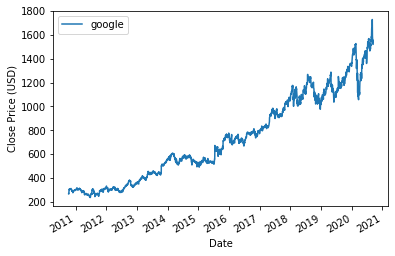

In [11]:
plot_timeseries_label(df, date_col, label_col)

## B. Data Processing

### B.1 Feature scaling 


https://machinelearningmastery.com/normalize-standardize-time-series-data-python/
https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/

Scaling features:
- purpose: Having features on a similar scale can help the gradient descent converge more quickly towards the minima.
- distance based algorithms: we scale our data before employing a distance based algorithm so that all the features contribute equally to the result. 

Types of scalers:
https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html
- StandardScaler: removes the mean and scales the data to unit variance
    - outliers have an influence when computing the empirical mean and standard deviation which shrink the range of the feature values
    - cannot guarantee balanced feature scales in the presence of outliers
- minmax scaler: normalizing to [0,1], sensitive to outliers
- maxabs scaler: absolute values scaled to [0,1], sensitive to outliers
- robust scaler: the centering and scaling statistics based on percentiles
    - not influenced by a few number of very large marginal outliers. 
    - resulting range of the transformed feature values is larger and are approximately similar. 
    - Outliers themselves are still present in the transformed data
- power transformer: applies a power transformation to each feature to make the data more Gaussian-like. 
    - Currently, PowerTransformer implements the Yeo-Johnson and Box-Cox transforms
    -  finds the optimal scaling factor to stabilize variance and mimimize skewness through maximum likelihood estimation

- QuantileTransformer: 
    - has an additional output_distribution parameter allowing to match a Gaussian distribution instead of a uniform distribution. Note that this non-parametetric transformer introduces saturation artifacts for extreme values
    - also can apply a non-linear transformation such that the probability density function of each feature will be mapped to a uniform distribution. In this case, all the data will be mapped in the range [0, 1], even the outliers which cannot be distinguished anymore from the inliers
    - robust to outliers in the sense that adding or removing outliers in the training set will yield approximately the same transformation on held out data. But contrary to RobustScaler, QuantileTransformer will also automatically collapse any outlier by setting them to the a priori defined range boundaries (0 and 1).

- normalizer:
    - rescales the vector for each sample to have unit norm, independently of the distribution of the samples


In [12]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

def fit_scaler(train_df, features_list: list, scale_type: str):
    """
    Fit scaler on train data
    inputs:
    - train_df: dataframe of x train data
    - features_list: list of features to be scaled
    - scale_type: type of scale to use (ie. standardize, normalize)

    scalers takes input (num_samples, num_features) and scales all features
    """
    scaler_dict = {
        "standard" : StandardScaler(), 
        "minmax" : MinMaxScaler(feature_range=(-1, 1)) , 
        "maxabs" : MaxAbsScaler(), 
        "robust": RobustScaler(quantile_range=(25, 75)),
        "power_yeo_johnson": PowerTransformer(method='yeo-johnson'),
        "power_box_cox" : PowerTransformer(method='box-cox'),
        "quartile_normal":  QuantileTransformer(output_distribution='normal'),
        "quartile_uniform": QuantileTransformer(output_distribution='uniform'),
        "normalizer": Normalizer()
    }
    
    scaler = scaler_dict[scale_type].fit(train_df[features_list])

    return scaler

In [13]:
# Normalize data before data splits
    # Note: Without normalizing the entire dataset, you cannot obtain good prediction performance at all
    # Normalizing the entire dataset might be justified because: You can normalize all data you have curently to predict tomorrow's output.

scaler = fit_scaler(df, features_list, scale_type)

df[features_list] = scaler.transform(df[features_list])
df.head()

,google,microsoft,nvidia,nasdaq,volatility,apple,amazon,ma7,ma21,MACD,upper_band,lower_band,ema,momentum,Date
20,-0.957284,-0.991536,-1.000000,-0.963407,-0.732971,-1.000000,-1.000000,-0.965992,-0.989406,0.372286,-0.983784,-0.975977,-0.959273,-0.957284,2010-10-11
21,-0.955581,-0.989228,-0.999254,-0.958502,-0.733787,-0.998163,-0.997958,-0.964406,-0.987309,0.374390,-0.983722,-0.971553,-0.957488,-0.955581,2010-10-12
22,-0.954305,-0.984322,-0.998117,-0.954353,-0.729980,-0.997238,-0.998733,-0.962300,-0.985080,0.376428,-0.984310,-0.966089,-0.956028,-0.954305,2010-10-13
23,-0.955888,-0.985380,-0.998757,-0.955673,-0.707954,-0.995985,-0.998520,-0.962028,-0.982941,0.376315,-0.986476,-0.958986,-0.956615,-0.955888,2010-10-14
24,-0.915469,-0.982399,-0.998295,-0.947562,-0.731067,-0.988803,-0.993127,-0.955282,-0.978672,0.405599,-0.974351,-0.963925,-0.929377,-0.915469,2010-10-15


### B.2 Data splits

- Train data: ~1-6 years
- val data: 6-7 years
- Test data: ~7-10 years

- First split by train and test
- Then split train into train and val later

In [14]:
# get year column
df["year"] = df[date_col].dt.date
df["year"] = df["year"].apply(lambda val: val.year)

start_year = min(df["year"].values)
end_year = max(df["year"].values)
duration = end_year - start_year

print("start_year: ", start_year)
print("end_year: ", end_year)
print("duration: ", duration)

start_year:  2010
end_year:  2020
duration:  10


In [15]:
train_df = df.loc[df["year"].isin(list(range(start_year, start_year + 7)))]
test_df = df.loc[df["year"].isin(list(range(start_year + 8, end_year)))]

print("train_df= " , train_df.shape)
print("test_df= " , test_df.shape)

train_df=  (1568, 16)
test_df=  (503, 16)


In [16]:
# # Fit the standardized scaler on the TRAIN data
# scaler = fit_scaler(train_df, features_list, scale_type)

# # Tranform both TRAIN and TEST data on the scaler fitted on TRAIN data
# train_df[features_list] = scaler.transform(train_df[features_list])
# test_df[features_list] = scaler.transform(test_df[features_list])

# print("train: ", train_df.shape)
# print("test: ", test_df.shape)
# test_df.head()

### B.3 Check for NaN values

In [17]:
def check_nan(df: pd.DataFrame, features_list: list):
    """
    Check for which features have nan values
    """
    features = []
    for feature in features_list:
        vals = df[feature].values
        if np.isnan(np.sum(vals)):
            features.append(feature)
    
    return features

In [18]:
# Check to see if there are any nan values in any features
    # nan values will be ignored/masked by lstm model
print("train: %d" %len(check_nan(train_df, features_list)))
print("test: %d" % len(check_nan(test_df, features_list)))

train: 0
test: 0


### B.4 Apply Fourier transform of target stock prices to denoise the signal and extracl global and local trends in the data

In [19]:
from numpy.fft import *
# from @theoviel at https://www.kaggle.com/theoviel/fast-fourier-transform-denoising
def filter_signal(signal, threshold=1e3):
    """
    Apply the fft to the signal
    Compute the frequencies associated with each coefficient
    Keep only the coefficients which have a low enough frequency (in absolute)
    Compute the inverse fft

    """
    fourier = rfft(signal)
    frequencies = rfftfreq(len(signal), d=20e-3/len(signal))
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

In [20]:
def denoise_fft(df:pd.DataFrame, features_list, label_col):
    """
    Denoise target signal using fourier transform to extract local and global trends
    """
    denoised = filter_signal(df[label_col].values)

    # if ifft results in 1 less element(weird bug), pad with last value
    if len(denoised) < len(df):
        diff = len(df) - len(denoised) 
        # pdb.set_trace()
        denoised = np.asarray(list(denoised) + [denoised[-1]] * diff)

    df["fft"] = denoised

    return df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


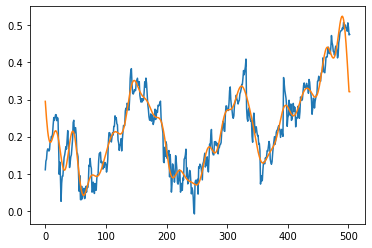

In [21]:
import matplotlib.pyplot as plt

train_df = denoise_fft(train_df, features_list, label_col)
test_df = denoise_fft(test_df, features_list, label_col)

# Visualize FFT denoised data
plt.plot(test_df[label_col].values, label='Raw')
plt.plot(test_df["fft"].values, label='Filtered')
plt.show()

# add feature
features_list.append("fft")

## C. LSTM model (Unidirectional and Bi-directional)

https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/

- Bidirectional LSTM: 
    - involves duplicating the first recurrent layer in the network so that there are now two layers side-by-side, then providing the input sequence as-is as input to the first layer and providing a reversed copy of the input sequence to the second.
    - Where LSTM learns linearly, Bidirectional LSTM learns from both past and future to predict current


    


### C.1 Define Custom dataset for LSTM model

In [22]:
import torch
from torch.utils.data import DataLoader, Dataset

class LSTMDataset(Dataset):
    def __init__(self, df:pd.DataFrame, features_list, date_col, time_steps, label_col):
        self.df = df
        self.features_list = features_list
        self.date_col = date_col
        self.time_steps = time_steps
        self.label_col = label_col
        self.data, self.labels = self.prepare_data(df, features_list, date_col, time_steps)
        
    def prepare_data(self, df: pd.DataFrame, features_list: list, date_col: str, time_steps: int):
        """
        Preparing data for CNN = sliding window 

        Inputs:
        df: dataframe of data (train or test)
        uids: uids that correspond to the labels, in correct order
        y: corresponding labels
        features_list: list of features to keep
        time_steps:  number of time_steps, default to 100

        Outputs:
        X data: (num_samples, num_time_steps, num_features)
        y data: (num_samples, )
        """

        # sort by date col
        df = df.sort_values(by=[date_col])
        data = df[self.features_list].values
        targets = df[self.label_col].values

        X_data = []
        y_data = []

        # Rolling window sequence, moves up by 1 data point every time
        for i in range(time_steps, len(data)):
            # Get sequence of length time_steps up till current i - 1
            X_data.append(data[i - time_steps : i])

            # Get stock price at i (label to predict)
            y_data.append(targets[i])

        X_data, y_data = np.array(X_data), np.array(y_data)
        X_data = X_data.reshape(len(X_data), time_steps, len(features_list))

        y_data = y_data.reshape(len(y_data))
        
        return X_data, y_data 
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        """
        X[index] = (time_steps, num_timesteps, features)
        Y[index] = (1)
        """
        X = self.data[index]
        y = self.labels[index].reshape(1)
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [23]:
# test dataset
dataset = LSTMDataset(train_df, features_list, date_col, time_steps, label_col)
print("number of features: ", len(features_list))
print("dataset data shape: ", dataset.data.shape)
print("dataset label shape: ", dataset.labels.shape)

number of features:  15
dataset data shape:  (1468, 100, 15)
dataset label shape:  (1468,)


### C.2 Define pytorch LSTM model

In [24]:
import torch
from torch import optim, nn
import pdb

class LSTM(nn.Module):

    def __init__(self, gpu:bool, num_features, hidden_size, num_layers, output_dim, device, is_bidirectional, dr=0.2):
        """
        - num_features: number of features for input
        - hidden_size: number of features for hidden state
        - num_layers: number of recurrent layers (ie. number of LSTM layers)
        - output_size: number of classes to predict
        """
        super(LSTM, self).__init__()

        self.gpu = gpu
        self.num_features = num_features
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device
        # output_dim set to 1 = predict 1 value
        self.output_dim = output_dim
        self.is_bidirectional = is_bidirectional

        # LSTM layers
            # If your input data is of shape (batch_size, time_steps, features) then you need batch_first=True 
            # If your input data is (time_steps, batch_size, features), then you don't need batch_first=True
        self.lstm = nn.LSTM(input_size=num_features, hidden_size=hidden_size, num_layers=num_layers, batch_first = True, bidirectional= is_bidirectional)
        self.dropout = nn.Dropout(p = dr)

        if self.is_bidirectional:
            # Linear layer with 1 output dimension to predict 1 value
            self.fc = nn.Linear(hidden_size * 2, self.output_dim)
        
        else:
            # Linear layer with 1 output dimension to predict 1 value
            self.fc = nn.Linear(hidden_size, self.output_dim)

    def forward(self, x):
        # x = (batch_size, time_steps num_features)
        # reset state of LSTM
        h0, c0 = self.init_hidden(x)

        # feed data and hidden states of this batch
        # out = (batch_size, time_steps, hidden_layers) 
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        # out = self.dropout(out)

        # out = (batch_size, time_steps, output_dim)
        # out[:,-1,:] = (batch_size, output_dim) 
            # get output from the last time step = represent the next prediction
        out = self.fc(out[:,-1,:])

        return out

    def init_hidden(self, x):
        # return zeros 
            # size = (num_layers, batch_size, num_hidden_layers) 
            # ie. for each layer, you have hidden states (= num of hidden layers) for each sample in batch.
        
        if self.is_bidirectional:
            h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).requires_grad_()
            c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).requires_grad_()

        else:
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()

        if self.gpu:
            return [t.to(self.device) for t in (h0, c0)]
        else:
            return [t for t in (h0, c0)]


### C.3 Train and evalute model on train and val dataset
- save best model
- early stopping enabled for faster training

In [25]:
class AverageMeter(object):
    """
    Function to calculate loss and accuracy during training
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [26]:
import pdb

def train(train_loader, optimizer, criterion, model, device):
    """
    Train model for every batch in sample for this current epoch
    """
    # set model to train mode
    model.train()

    train_loss = AverageMeter()

    # go through every batch for this current epoch
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # pdb.set_trace()

        # x_batch = (batch_size, time_step, num_features) 
        x_batch = x_batch.to(device)
        # y_batch = (batch_size, num_features) 
        y_batch = y_batch.to(device)
        N = x_batch.size(0)
        
        # Set gradients to zero before starting to do back propagation because pytorch accumulates the gradients on subsequent backward passes
        optimizer.zero_grad()

        # y_scores = (batch_size, output_dim)
        y_scores = model(x_batch)

        loss = criterion(y_scores, y_batch)
        loss.backward()
        optimizer.step()

        train_loss.update(loss.item())

    # return average train loss for epoch
    return train_loss.avg

In [27]:
def validate(val_loader, optimizer, criterion, model, device):
    """
    Validate trained model on validation dataset for this epoch
    """
    # set model to eval mode
    model.eval()
    val_loss = AverageMeter()

    # stop gradient descent / back prop during evaluation
    with torch.no_grad():
        for i, (x_batch, y_batch) in enumerate(val_loader):
            # x_batch = (batch_size, time_step, num_features) 
            x_batch = x_batch.to(device)
            # y_batch = (batch_size, num_features)
            y_batch = y_batch.to(device)
            N = x_batch.size(0)

            # y_scores = (batch_size, output_dim) 
            y_scores = model(x_batch)
            loss = criterion(y_scores, y_batch)

            val_loss.update(loss.item())
    
    return val_loss.avg

In [28]:
import tqdm
from tqdm import tqdm

def run_model(train_loader, val_loader, optimizer, criterion, model, device, data_path, patience, num_epochs, model_name, early_stop):
    """
    Train and evaluate per epoch and visualize loss over time
    """
    best_loss = float('inf')
    train_losses = []
    val_losses = []
    epochs_trained = num_epochs
    best_model = None

    for epoch in range(1, num_epochs + 1): 
        loss_train = train(train_loader, optimizer, criterion, model, device)
        loss_val = validate(val_loader, optimizer, criterion, model, device)

        train_losses.append(loss_train)
        val_losses.append(loss_val)

        print("epoch: ", epoch, "train loss: ", loss_train, "val_loss: ", loss_val)

        # if lowest loss, save model
        if loss_val < best_loss:
            best_loss = loss_val
            es = 0
            torch.save(model.state_dict(), data_path + model_name)
            best_model = model

        else:
            # if loss is not going down
            if early_stop:
            
                # patience count
                es +=1

                if es > patience:
                    epochs_trained = epoch
                    print("Early stopping with lowest loss: ", best_loss)
                    break

    return train_losses, val_losses, epochs_trained, best_model


In [29]:
import matplotlib.pyplot as plt

def run_LSTM(train_df: pd.DataFrame, val_df: pd.DataFrame, is_bidirectional:bool, early_stop: bool, num_features = 1, num_epochs = 100, patience = 20, learning_rate = 0.01, num_layers = 1, hidden_size = 100, output_dim = 1, model_name = "lstm_model_stocks.pt"):
    """
    Run and evaluate LSTM model
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = LSTM(gpu, num_features, hidden_size, num_layers, output_dim, device, is_bidirectional, dr=0.2)
    model.to(device)

    # optimizer = adam
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    # loss = MSELoss for regression
    criterion = torch.nn.MSELoss(reduction='mean')

    # data loader:
    train_loader = DataLoader(dataset = LSTMDataset(train_df, features_list, date_col, time_steps, label_col), shuffle = False, batch_size = 16)
    val_loader = DataLoader(dataset = LSTMDataset(val_df, features_list, date_col, time_steps, label_col), shuffle = False, batch_size = 16)

    # run train and evaluation = save best model
    train_losses, val_losses, epochs_trained, best_model = run_model(train_loader, val_loader, optimizer, criterion, model, device, data_path, patience, num_epochs, model_name, early_stop)

    # plot train and val losses
    epochs = list(range(1, epochs_trained + 1))
    plt.plot(epochs, train_losses, 'g', label='Training loss')
    plt.plot(epochs, val_losses, 'b', label='validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return best_model


In [30]:
# Split into train and validation (15% valid)
train_df = train_df.sort_values(by=[date_col])
valid_idx = int(len(train_df) * 0.15)

val_df = train_df.iloc[:valid_idx]
train_df = train_df.iloc[valid_idx:]

print("train_df: ", train_df.shape)
print("val_df: ", val_df.shape)

train_df:  (1333, 17)
val_df:  (235, 17)


epoch:  1 train loss:  0.013231844183722457 val_loss:  0.3132929239008162
epoch:  2 train loss:  0.016757545173306472 val_loss:  0.36631695760620964
epoch:  3 train loss:  0.02804514238045951 val_loss:  0.43025580710834926
epoch:  4 train loss:  0.034917364326713884 val_loss:  0.4219972524378035
epoch:  5 train loss:  0.04294027035934843 val_loss:  0.36228993866178727
epoch:  6 train loss:  0.04266804509470836 val_loss:  0.3102947506639693
epoch:  7 train loss:  0.03863402846158911 val_loss:  0.2538520826233758
epoch:  8 train loss:  0.03083989551249453 val_loss:  0.2148226002852122
epoch:  9 train loss:  0.02539871379420406 val_loss:  0.188661374979549
epoch:  10 train loss:  0.023564703203401923 val_loss:  0.14721024367544386
epoch:  11 train loss:  0.018365594106888657 val_loss:  0.13346534967422485
epoch:  12 train loss:  0.016071266501687484 val_loss:  0.0997834089729521
epoch:  13 train loss:  0.011723679067225627 val_loss:  0.07770491060283449
epoch:  14 train loss:  0.008726488

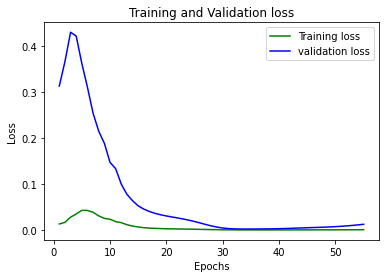

In [31]:
lstm_model = run_LSTM(train_df, val_df, is_bidirectional = False, early_stop= True, num_features = len(features_list))

epoch:  1 train loss:  0.0158139129118167 val_loss:  0.28849894139501786
epoch:  2 train loss:  0.01649239721789341 val_loss:  0.32346656256251866
epoch:  3 train loss:  0.02417072907981212 val_loss:  0.41830642686949837
epoch:  4 train loss:  0.030956187002933195 val_loss:  0.39638572600152755
epoch:  5 train loss:  0.03863380055433178 val_loss:  0.3427388038900163
epoch:  6 train loss:  0.03781323914471357 val_loss:  0.28910884261131287
epoch:  7 train loss:  0.0334517016968582 val_loss:  0.20952695773707497
epoch:  8 train loss:  0.023536359666487 val_loss:  0.17902706563472748
epoch:  9 train loss:  0.020563231957473758 val_loss:  0.1386483477221595
epoch:  10 train loss:  0.01492581905758692 val_loss:  0.08847848739888933
epoch:  11 train loss:  0.00888318052164276 val_loss:  0.0678749072055022
epoch:  12 train loss:  0.006376939902349415 val_loss:  0.05252835940983561
epoch:  13 train loss:  0.004867792991574742 val_loss:  0.04395795406566726
epoch:  14 train loss:  0.00405421113

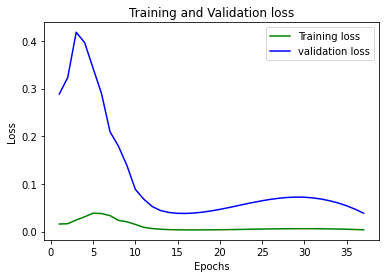

In [38]:
bi_lstm_model = run_LSTM(train_df, val_df, is_bidirectional = True, early_stop= True, num_features = len(features_list))

### C.4 Evalute trained models on val dataset

In [44]:
def evaluate_model(data_loader, model):
    model.eval()
    criterion = torch.nn.MSELoss()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    test_loss = AverageMeter()
    y_scores = []
    y_trues = []

    for data, y_true in data_loader:
        # data = (1, time_steps, num_features) =  [1, 100, 1]
        data = data.to(device)
        # y_true = (1, num_features) = [1,1]
        y_true = y_true.to(device)

        y_score = model(data)
        y_scores.append(y_score)
        y_trues.append(y_true)

        loss = criterion(y_score, y_true)
        test_loss.update(loss.item())

    print("loss: ", test_loss.avg)

    return np.asarray(y_scores), np.asarray(y_trues)

In [45]:
def graph_predictions(y_scores, y_trues):
    # plot train and val losses
    time_array = range(1, len(y_scores)+1)

    plt.plot(time_array, y_scores, 'g', label='Prediction')
    plt.plot(time_array, y_trues, 'b', label='Truth')
    plt.title('Stock price prediction')
    plt.xlabel('Time steps')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
    

loss:  0.012764153601946654


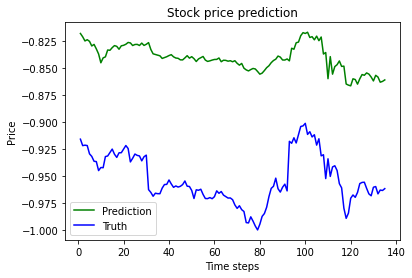

In [46]:
val_loader = DataLoader(dataset = LSTMDataset(val_df, features_list, date_col, time_steps, label_col), shuffle = False)

# Test lstm_model on val dataset
y_scores, y_trues = evaluate_model(val_loader, lstm_model)

graph_predictions(y_scores, y_trues)

loss:  0.03887926625708739


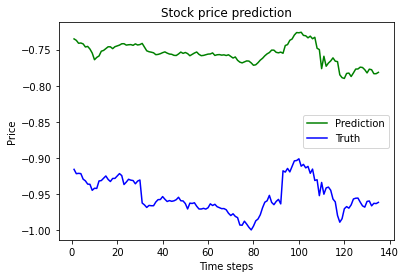

In [47]:
# Test bilstm_model 
y_scores, y_trues = evaluate_model(val_loader, bi_lstm_model)
graph_predictions(y_scores, y_trues)

### C.5 Evalute trained models on test dataset

loss:  0.09027993763108315


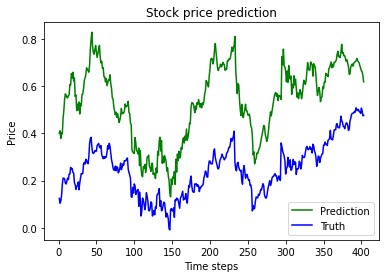

In [48]:
test_loader = DataLoader(dataset = LSTMDataset(test_df, features_list, date_col, time_steps, label_col), shuffle = False)

# Test lstm_model 
y_scores, y_trues = evaluate_model(test_loader, lstm_model)
graph_predictions(y_scores, y_trues)

loss:  0.7721046601184101


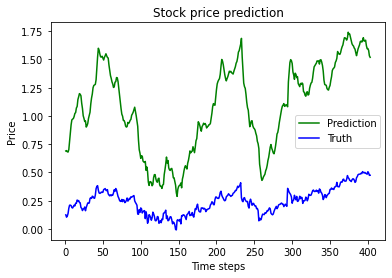

In [50]:
# Test bi-lstm model
y_scores, y_trues = evaluate_model(test_loader, bi_lstm_model)
graph_predictions(y_scores, y_trues)